##  Modeling the Impact of Four Different Decisions Application with Ensemble Simulations on Total Evapotranspiration in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

The Structure for Unifying Multiple Modeling Alternative (SUMMA) was developed to enable the controlled and systematic evaluation of multiple model representations of hydrologic process and scaling behavior (Clark et al., 2015a). SUMMA has several beneficial capabilities that assist with a unifying framework. 

This study looked at four different decisions application with ensemble simulations:

- 1) soil-category dataset: (a) STATSGO dataset (STAS), (b) STAS-RUC, (c) ROSETTA (merged Rosetta table with STAS-RUC)

- 2) vegetation category dataset: (a) USGS 24/27 category dataset (USGS), (b) MODIFIED_IGBP_MODIS_NOAH (MODIS 20-category dataset)

- 3) choice of function for the soil moisture control on stomatal ressitance: (a) NoahType (thresholded linear function of volumetric liquid water content), (b) CLM_Type (thresholded linear function of matric head), (c) SiB_Type (exponential of the log of matric head)

- 4) choice of function for stomatal resistance: (a) Ball-Berry, (b) Jarvis, (c) simple Resistance


In this Jupyter Notebook, the pySUMMA library is used to show how to use pysumma to apply ensemble simulation for the different decisions' combination. First, the four different decisions applications are described. Next, the Methods section describes how the pySUMMA can be used to apply ensemble simulations with four different decisions applications.  The Results section shows how to use pySUMMA and the Pandas library to display and compare the ensemble simulation outputs and observations.

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

## 2. Background

### 2-1) soil-category dataset parameterizations available in SUMMA

### 2-2) vegetation-category dataset parameterizations available in SUMMA

### 2-3) the soil moisture control on stomatal resistance parameterizations available in SUMMA

### 2-4) The stomatal resistance parameterizations available in SUMMA

#### 1) The simple soil resistance method

\begin{equation*}
r_{{s},{sun}} = r_{{s},{shd}} = \frac{r_{0c}}{\beta_v} \,\,\,\, 
\end{equation*}
$r_{0c} \,(s\,m^{-1})$ : the minimum stomatal resistance ,     ${\beta_v}\,(-)$ : the total soil water stress function

\begin{equation*}
{\beta_v} = \sum f_{{roots},{j}} \beta_{{v},{j}}  +  f_{roots}^{aq} \beta_{v}^{aq}
\end{equation*}
$z_{soil}$ : the soil depth, $f_{{roots},{j}}$ : the root density in the $j$-th soil layer
$\beta_{{v},{j}}$ : the water availability stress funtion in the $j$-th soil layer <br/>
$f_{roots}^{aq}$ : the fraction of roots for the aquifer, $\beta_{v}^{aq}$ : water availability stress function for the aquifer

For additional detail, see: https://github.com/uva-hydroinformatics/pysumma/tree/master/sopron_2018_notebooks/simple1.png

#### 2) The Ball-Berry method
 

\begin{equation*}
g_i = v_t  \frac{A_i}{c_{air}}\frac{e_{air}}{e_{sat}(T_{veg})}P_{air} + g_{min}\beta_v, \,\,\,\,   i = sun, shd
\end{equation*}

$g_i\, (micromol \,\, m^{-2} s^{-1})$ : Stomatal conductance per unit sunlit and shaded leaf area <br/> 
$A_i\, (micromol \,\, m^{-2} s^{-1})$ : a function of the rate of photosynthesis <br/>
$c_{air}\, (Pa)$ : $CO_2$ concentration at the leaf surface (time varying model forcing, representing carbon fertilization) <br/>
$g_{min}\, (micromol \,\, m^{-2} s^{-1})$ : the minimum stomatal conductance <br/>
$v_t\,(-)$ : an empirical parameter to relate transpiration to the $CO_2$ flux, where a greater value of $v_t$ means the leaf consumes more water to produce the same carbon mass <br/>

For additinoal detail, see: https://github.com/uva-hydroinformatics/pysumma/tree/master/sopron_2018_notebooks/BallBerry.png

#### 3) The Jarvis method

\begin{equation*}
r_{{s},{i}} = \frac{r_{0c}}{f(Q_{{PAR},{i}})f(T_{air})f(e_{d})\beta_v} \,\,\,\,   i = sun, shd
\end{equation*}

the subscript $i$ defines either sunlit or shaded leaves <br/> 
$f(Q_{{PAR},{i}})$, $f(T_{air})$, $f(e_{d})$ : all limited to the range 0-1, represent the effects of photosynthetically-active radiation(PAR), air temperature, and vapor pressure deficit, where $ Q_{{PAR},{i}} $ represents PAR absorbed on sunlit or shaded leaves <br/> 

For additional detail, see: https://github.com/uva-hydroinformatics/pysumma/tree/master/sopron_2018_notebooks/Jarvis.png

The above images are taken from the Stomal Resistance Method section within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Download SUMMA Model Instance from HydroShare

In [1]:
import pysumma as ps
import pysumma.hydroshare_utils as utils
from hs_restclient import HydroShare
import shutil, os
import subprocess

In [2]:
resource_id = '1f3f310af8364d2aa3e6a9459152a21c'
instance = utils.download_model_instance(resource_id)
instance

Username: choi
Password for choi: ········


'SummaModel_ReynoldsAspenStand_StomatalResistance_sopron'

In [3]:
!cd SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/; chmod +x ./installTestCases_local.sh
!cd SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/; ./installTestCases_local.sh

TestCases installed


### 2) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [4]:
from ipyleaflet import Map, GeoJSON
import json, os

In [5]:
m = Map(center=[43.06745, -116.75489], zoom=15)
instance = 'SummaModel_ReynoldsAspenStand_StomatalResistance_sopron'
with open(os.getcwd() + '/' + instance + '/data/reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### 3) Create pySUMMA Simulation Object and Set Simulation periods

In [6]:
# path to the SUMMA filemanager file
import os
instance = 'SummaModel_ReynoldsAspenStand_StomatalResistance_sopron'
file_manager = os.getcwd() + '/' + instance + '/settings/summa_fileManager_riparianAspenSimpleResistance.txt'

In [7]:
executable = "/code/bin/summa.exe"

In [8]:
# Create pySUMMA Simulation Object
import pysumma as ps
S = ps.Simulation(executable, file_manager)

In [9]:
# set the simulation start and finish times
S.decisions['simulStart'] = "2006-07-01 00:00"
S.decisions['simulFinsh'] = "2007-08-20 00:00"

In [10]:
S.manager["output_prefix"].value = "different_decisions"

In [11]:
S._write_configuration()

### 4) Ensemble Application for Four Different Decisions Application

In [12]:
# create parameterizations(methods) ensemble
decision_options = {
    'soilCatTbl': ["STAS", "STAS-RUC", "ROSETTA"],
    'vegeParTbl': ["USGS", "MODIFIED_IGBP_MODIS_NOAH"],
    "soilStress": ["NoahType", "CLM_Type", "SiB_Type"],
    'stomResist': ["BallBerry", "Jarvis", "simpleResistance"]
}

In [13]:
# create config for parameterizations ensemble
config = ps.ensemble.decision_product(decision_options)
len(config)

54

In [14]:
%%time
e = ps.Ensemble(executable, file_manager, config, num_workers=len(config))

CPU times: user 403 ms, sys: 197 ms, total: 600 ms
Wall time: 899 ms


In [15]:
%%time
e.run('local', prerun_cmds=['export OMP_NUM_THREADS=1','export LD_LIBRARY_PATH=/opt/local/lib'])

CPU times: user 6.81 s, sys: 1.31 s, total: 8.13 s
Wall time: 1min 51s


In [ ]:
#e.monitor()
##check status
#for i, (n, s) in enumerate(e.simulations.items()):
#    if s.status != 'Success':
#        print(i, f'{n:100}', s.status)
## open output
#output_ensemble_decisions = e.merge_output()        

## 4. Results

In [16]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.figsize(x=20, y=5)

### 1) Get SUMMA output list

In [17]:
# set output variable we want
output_variables = ['scalarCanopyTranspiration','scalarCanopyEvaporation','scalarGroundEvaporation']
# check output directory
output_path = S.manager["output_path"].value
# check SUMMA output file 
name_list = os.listdir(output_path)
full_list = [os.path.join(output_path,i) for i in name_list]
sorted_list = sorted(full_list)
run_suffix = 'different_decisions'
output_list = [x for x in sorted_list if run_suffix in x]

### 2) Create Pandas Dataframe for the first group of ensemble simulations

- (The first group) ROSETTA + MODIFIED_IGBP_MODIS_NOAH + Others

In [18]:
sim_start_date = "2006-07-01"
sim_end_date = "2007-08-20"
graph_start_date = "2007-06-01"
graph_end_date = "2007-08-20"
arr = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
H_index = pd.date_range(sim_start_date, sim_end_date, freq='1H')
total_et_f = pd.DataFrame(index=arr)
ensemble_list_all = []
for i, s_var in enumerate(output_list[0:9]):
    ds = xr.open_dataset(output_list[i])
    ensemble_list = output_list[i].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly
total_et_f.head()

,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++CLM_Type++BallBerry,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++CLM_Type++Jarvis,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++CLM_Type++simpleResistance,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++NoahType++BallBerry,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++NoahType++Jarvis,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++NoahType++simpleResistance,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++SiB_Type++BallBerry,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++SiB_Type++Jarvis,ROSETTA++MODIFIED_IGBP_MODIS_NOAH++SiB_Type++simpleResistance
0,-0.019830,-0.014526,-0.021303,-0.017708,-0.011787,-0.053402,-0.018221,-0.012955,-0.018464
1,-0.018874,-0.013912,-0.019793,-0.016894,-0.011283,-0.049276,-0.017352,-0.012394,-0.016847
2,-0.017182,-0.012488,-0.017227,-0.015324,-0.010036,-0.043871,-0.015768,-0.011109,-0.015044
3,-0.015221,-0.010650,-0.015283,-0.013371,-0.008097,-0.041709,-0.013804,-0.009255,-0.013150
4,-0.014175,-0.009776,-0.015181,-0.012392,-0.007260,-0.040365,-0.012833,-0.008437,-0.012948


#### Add Observation data to compare with ensemble simulation

In [19]:
# create observation data object
Val_eddyFlux = xr.open_dataset(file_manager.split('/settings')[0]+'/data/validationData/ReynoldsCreek_eddyFlux.nc')
# read Total Evapotranspiration(LE-wpl) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux.variables['LE-wpl']
# create dates(X-axis) attribute from validation netcdf file
dates = Val_eddyFlux.coords['time'].data
# Change unit from Wm-2 to mm/hr (1 Wm-2 = 0.0864 MJm-2day-1, 1 MJm-2day-1 = 0.408 mmday-1, 1day = 24h)
data_values = Obs_Evapotranspitaton.data/2260000*3600*1.4   #*0.0864*0.408/24
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc[graph_start_date:graph_end_date]
# select aspen obervation station among three different stations
df_filt.columns = ['-','Observation (aspen)','-']
# resample data by the average for hour of day
df_gp_hr = df_filt.groupby([df_filt.index.hour, df_filt.index.minute]).mean()
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

#### Display SUMMA output for the first group of ensemble simulations

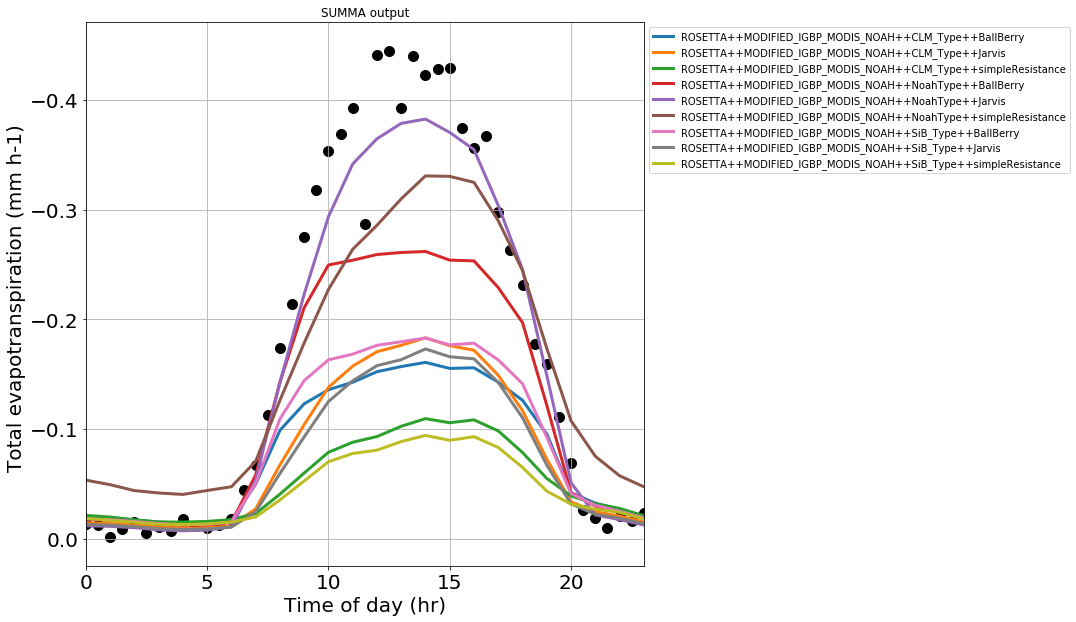

In [20]:
ax = total_et_f.plot(figsize=(10,10),linewidth=3.0)
ax.invert_yaxis()
ax.set_title("SUMMA output")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
plt.show()

### 3) Create Pandas Dataframe for the second group of ensemble simulations

- (The second group) ROSETTA + USGS + Others

In [21]:
total_et_f = pd.DataFrame(index=arr)
#ensemble_list_all = []
for i, s_var in enumerate(output_list[9:18]):
    ds = xr.open_dataset(output_list[i+9])
    ensemble_list = output_list[i+9].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly
total_et_f.head()

,ROSETTA++USGS++CLM_Type++BallBerry,ROSETTA++USGS++CLM_Type++Jarvis,ROSETTA++USGS++CLM_Type++simpleResistance,ROSETTA++USGS++NoahType++BallBerry,ROSETTA++USGS++NoahType++Jarvis,ROSETTA++USGS++NoahType++simpleResistance,ROSETTA++USGS++SiB_Type++BallBerry,ROSETTA++USGS++SiB_Type++Jarvis,ROSETTA++USGS++SiB_Type++simpleResistance
0,-0.019023,-0.015096,-0.021303,-0.016692,-0.012626,-0.053402,-0.017250,-0.013358,-0.018464
1,-0.018107,-0.014461,-0.019793,-0.015925,-0.012089,-0.049276,-0.016446,-0.012798,-0.016847
2,-0.016453,-0.013000,-0.017227,-0.014406,-0.010808,-0.043871,-0.014877,-0.011479,-0.015044
3,-0.014511,-0.011151,-0.015283,-0.012467,-0.008854,-0.041709,-0.012949,-0.009630,-0.013150
4,-0.013495,-0.010267,-0.015181,-0.011518,-0.007990,-0.040365,-0.012015,-0.008810,-0.012948


#### Display SUMMA output for the second group of ensemble simulations

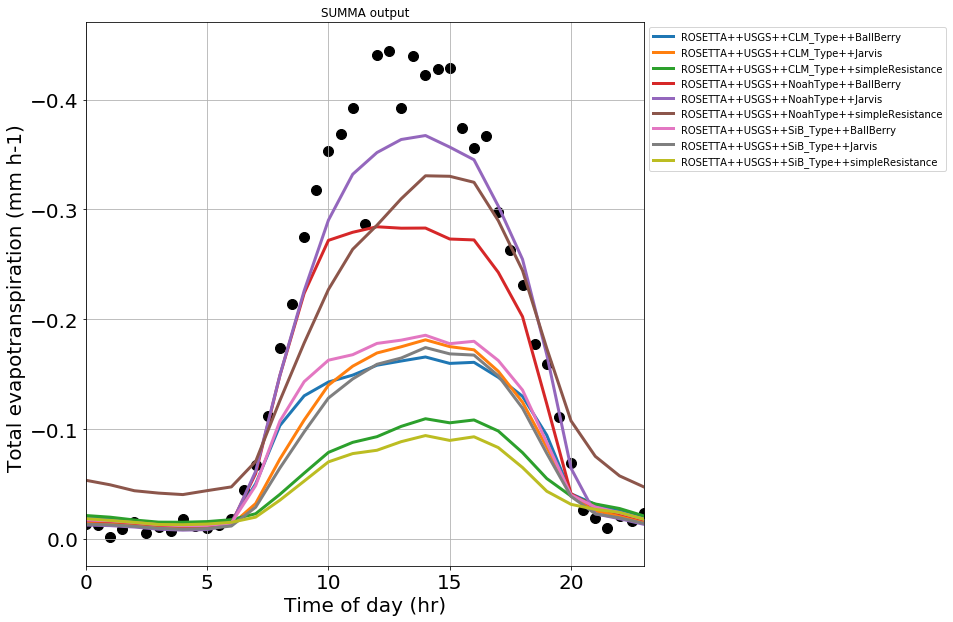

In [22]:
ax = total_et_f.plot(figsize=(10,10),linewidth=3.0)
ax.invert_yaxis()
ax.set_title("SUMMA output")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
plt.show()

### 4) Create Pandas Dataframe for the third group of ensemble simulations

- (The third group) STAS + MODIFIED_IGBP_MODIS_NOAH + Others

In [23]:
total_et_f = pd.DataFrame(index=arr)
#ensemble_list_all = []
for i, s_var in enumerate(output_list[18:27]):
    ds = xr.open_dataset(output_list[i+18])
    ensemble_list = output_list[i+18].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly

#### Display SUMMA output for the third group of ensemble simulations

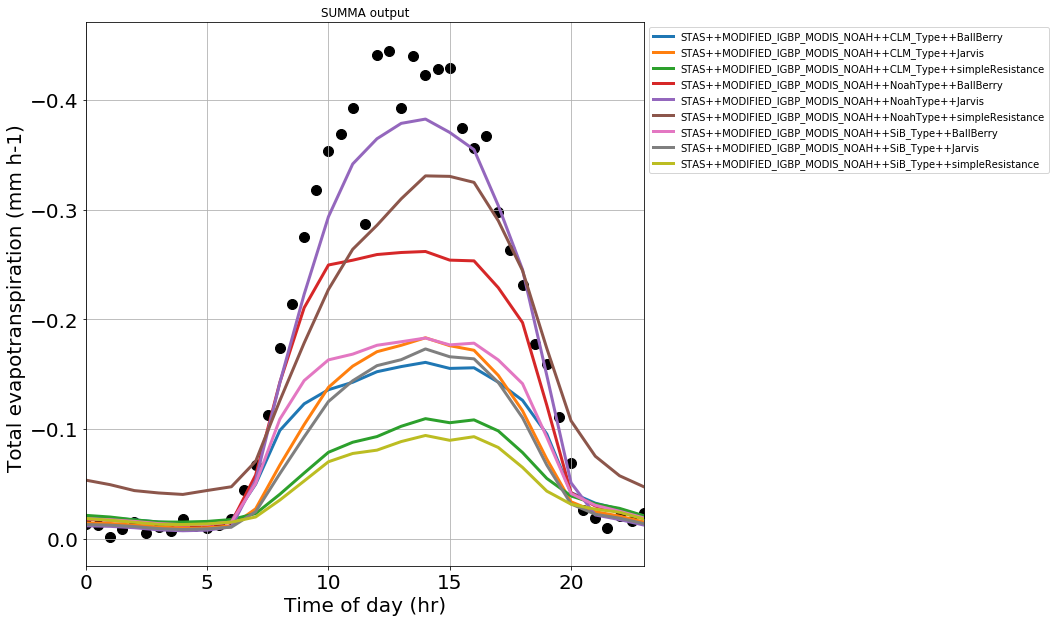

In [24]:
ax = total_et_f.plot(figsize=(10,10),linewidth=3.0)
ax.invert_yaxis()
ax.set_title("SUMMA output")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
plt.show()

### 5) Create Pandas Dataframe for the fourth group of ensemble simulations

- (The fourth group) STAS + USGS + Others

In [25]:
total_et_f = pd.DataFrame(index=arr)
#ensemble_list_all = []
for i, s_var in enumerate(output_list[27:36]):
    ds = xr.open_dataset(output_list[i+27])
    ensemble_list = output_list[i+27].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly

#### Display SUMMA output for the fourth group of ensemble simulations

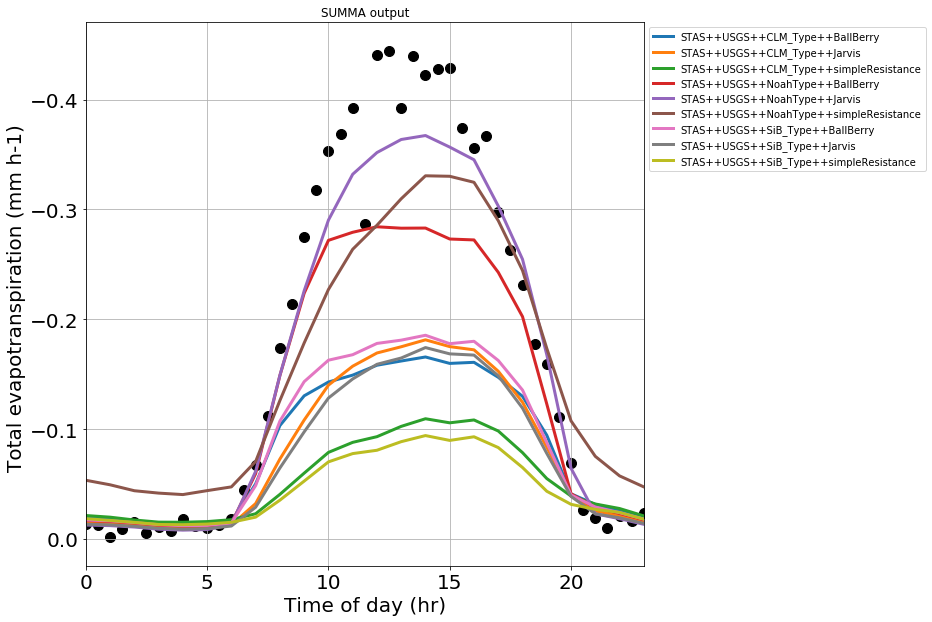

In [26]:
ax = total_et_f.plot(figsize=(10,10),linewidth=3.0)
ax.invert_yaxis()
ax.set_title("SUMMA output")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
plt.show()

### 6) Create Pandas Dataframe for the fifth group of ensemble simulations

- (The fifth group) STAS-RUC + MODIFIED_IGBP_MODIS_NOAH + Others

In [27]:
total_et_f = pd.DataFrame(index=arr)
#ensemble_list_all = []
for i, s_var in enumerate(output_list[36:45]):
    ds = xr.open_dataset(output_list[i+36])
    ensemble_list = output_list[i+36].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly

#### Display SUMMA output for the fifth group of ensemble simulations

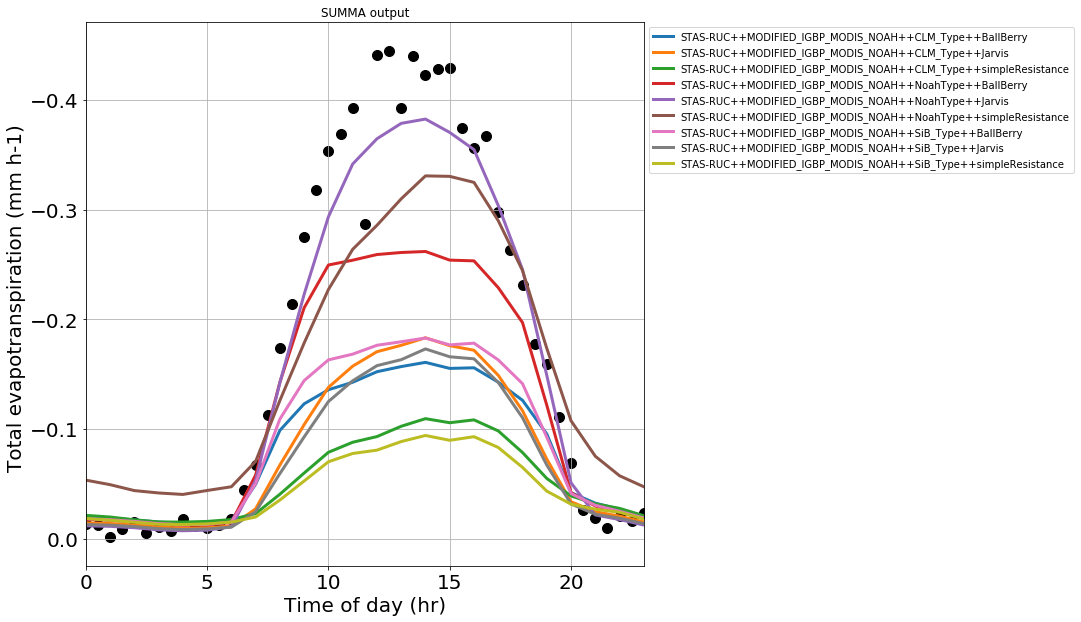

In [28]:
ax = total_et_f.plot(figsize=(10,10),linewidth=3.0)
ax.invert_yaxis()
ax.set_title("SUMMA output")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
plt.show()

### 7) Create Pandas Dataframe for the sixth group of ensemble simulations

- (The fifth group) STAS-RUC + USGS + Others

In [29]:
total_et_f = pd.DataFrame(index=arr)
#ensemble_list_all = []
for i, s_var in enumerate(output_list[45:54]):
    ds = xr.open_dataset(output_list[i+45])
    ensemble_list = output_list[i+45].split("output_++")[1].split("++_timestep")[0]
    ensemble_list_all.append(ensemble_list)
    total_et_data = (ds['scalarCanopyTranspiration'] + ds['scalarCanopyEvaporation'] + ds['scalarGroundEvaporation'])*3600*1.2
    df = pd.DataFrame(total_et_data.values, index=H_index)
    df.index = df.index.round("H")
    df = df.loc[graph_start_date:graph_end_date]
    df_hourly = df.resample("H").mean()
    total_et_hourly = df_hourly.groupby(df_hourly.index.hour).mean()
    total_et_f[ensemble_list] = total_et_hourly

#### Display SUMMA output for the sixth group of ensemble simulations

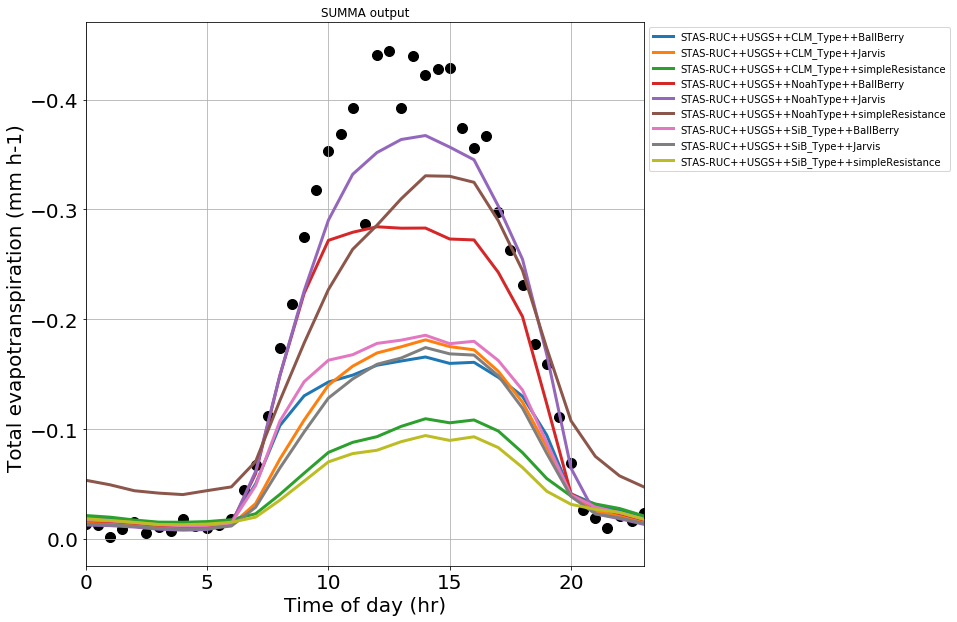

In [30]:
ax = total_et_f.plot(figsize=(10,10),linewidth=3.0)
ax.invert_yaxis()
ax.set_title("SUMMA output")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
ax.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black', s=100)
# add x, y label
ax.set_xlabel('Time of day (hr)', fontsize=20)
ax.set_ylabel('Total evapotranspiration (mm h-1) ', fontsize=20)
# show up the legend
#ax.legend(fontsize=17)
ax.tick_params(labelsize = 20)
ax.grid('on')
plt.show()